In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
import warnings
warnings.filterwarnings('ignore')

# Set the aesthetics for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

In [2]:
# --------- DATA LOADING AND CLEANING ---------
# Assuming you're starting with the raw Excel file

df = pd.read_excel("D:/capstone/datasets/Affinity - State - Daily.xlsx")
print(f"Raw dataset shape: {df.shape}")

# Check for column names
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Inspect data types
print("\nData types:")
print(df.dtypes.head())

Raw dataset shape: (50694, 29)

Columns in the dataset:
['year', 'month', 'day', 'statefips', 'freq', 'spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4', 'provisional']

Data types:
year          int64
month         int64
day           int64
statefips     int64
freq         object
dtype: object


In [3]:
# 1. Convert string values of "." to NaN, but only for numeric columns
print("\nHandling missing values...")
# First, identify the non-numeric columns
non_numeric_cols = ['freq']  # Add any other non-numeric columns here

# Now handle the conversion only for potential numeric columns
for col in df.columns:
    if col not in non_numeric_cols and df[col].dtype == object:
        df[col] = df[col].replace('.', np.nan).astype(float)


Handling missing values...


In [4]:
# 2. Create date column
print("Creating date column...")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# 3. Check for missing values in key columns
missing_values = df[['date', 'spend_all_q1', 'spend_all_q4']].isna().sum()
print("\nMissing values in key columns:")
print(missing_values)

# 4. Filter out rows with missing values in target columns
df_clean = df.dropna(subset=['spend_all_q1', 'spend_all_q4'])
print(f"\nRows after removing missing values: {len(df_clean)}")

Creating date column...

Missing values in key columns:
date               0
spend_all_q1    4587
spend_all_q4    3606
dtype: int64

Rows after removing missing values: 44145


In [5]:
# 5. Check for outliers using Z-score
print("\nChecking for outliers...")
z_scores_q1 = np.abs(stats.zscore(df_clean['spend_all_q1'].dropna()))
z_scores_q4 = np.abs(stats.zscore(df_clean['spend_all_q4'].dropna()))

# Count potential outliers (Z-score > 3)
outliers_q1 = np.sum(z_scores_q1 > 3)
outliers_q4 = np.sum(z_scores_q4 > 3)

print(f"Potential outliers in Q1 (Z-score > 3): {outliers_q1}")
print(f"Potential outliers in Q4 (Z-score > 3): {outliers_q4}")


Checking for outliers...
Potential outliers in Q1 (Z-score > 3): 178
Potential outliers in Q4 (Z-score > 3): 239


In [6]:
# 6. Create time series dataset
df_timeseries = df_clean[['date', 'spend_all_q1', 'spend_all_q4']].copy()
df_timeseries = df_timeseries.sort_values('date')

# 7. Filter to recovery period
df_recovery = df_timeseries[df_timeseries['date'] >= '2021-01-01']
print(f"\nFull clean dataset size: {len(df_timeseries)}")
print(f"Recovery dataset size: {len(df_recovery)}")

# Save cleaned datasets
df_timeseries.to_csv('clean_timeseries_data.csv', index=False)
df_recovery.to_csv('clean_recovery_data.csv', index=False)

# --------- EXPLORATORY DATA ANALYSIS ---------
print("\n\nStarting exploratory data analysis...")


Full clean dataset size: 44145
Recovery dataset size: 28215


Starting exploratory data analysis...


In [7]:
# 1. Descriptive statistics
recovery_stats_q1 = df_recovery['spend_all_q1'].describe()
recovery_stats_q4 = df_recovery['spend_all_q4'].describe()

# Create a comparison DataFrame
stats_comparison = pd.DataFrame({
    'Low Income (Q1)': recovery_stats_q1,
    'High Income (Q4)': recovery_stats_q4,
    'Difference': recovery_stats_q1 - recovery_stats_q4
})
print("\nDescriptive Statistics (Recovery Phase):")
print(stats_comparison.round(4))


Descriptive Statistics (Recovery Phase):
       Low Income (Q1)  High Income (Q4)  Difference
count       28215.0000        28215.0000      0.0000
mean            0.1623            0.1170      0.0453
std             0.1091            0.1064      0.0027
min            -0.3000           -0.5550      0.2550
25%             0.0918            0.0509      0.0409
50%             0.1640            0.1060      0.0580
75%             0.2370            0.1780      0.0590
max             0.6490            0.6560     -0.0070


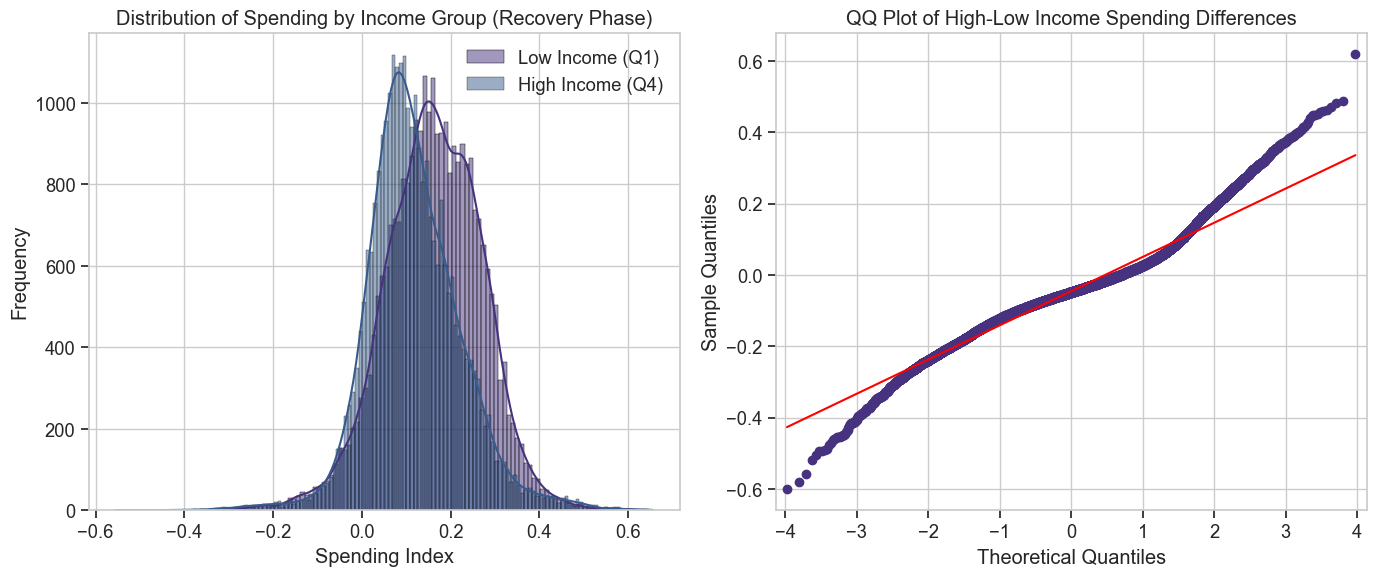

In [8]:
# 2. Visualization of distributions
plt.figure(figsize=(14, 6))
# Histogram of spending by income group
plt.subplot(1, 2, 1)
sns.histplot(df_recovery['spend_all_q1'], alpha=0.5, label='Low Income (Q1)', kde=True)
sns.histplot(df_recovery['spend_all_q4'], alpha=0.5, label='High Income (Q4)', kde=True)
plt.title('Distribution of Spending by Income Group (Recovery Phase)')
plt.xlabel('Spending Index')
plt.ylabel('Frequency')
plt.legend()

# QQ plot to check distribution of differences
plt.subplot(1, 2, 2)
diff = df_recovery['spend_all_q4'] - df_recovery['spend_all_q1']
sm.qqplot(diff, line='s', ax=plt.gca())
plt.title('QQ Plot of High-Low Income Spending Differences')
plt.tight_layout()
plt.show()

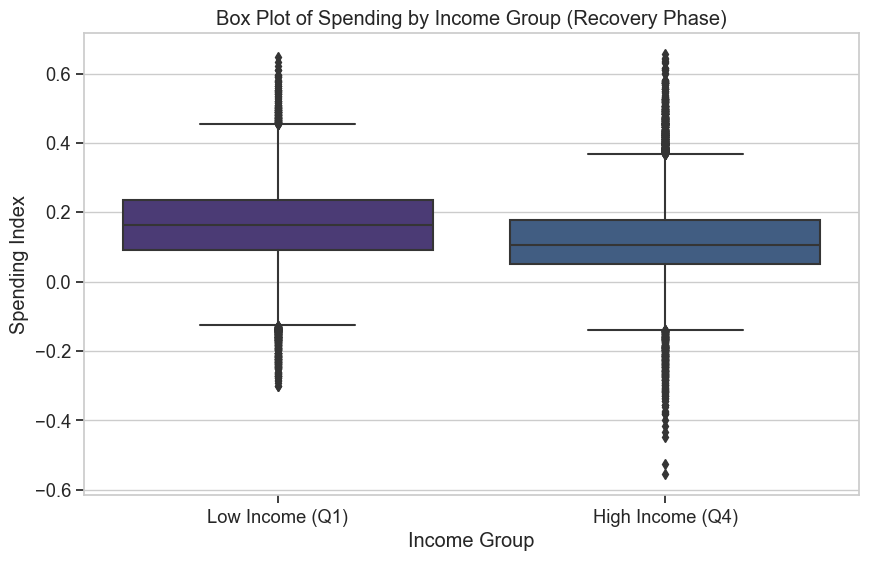

In [9]:
# Box plots
plt.figure(figsize=(10, 6))
boxplot_data = pd.melt(df_recovery[['spend_all_q1', 'spend_all_q4']],
                       var_name='Income Group', value_name='Spending Index')
boxplot_data['Income Group'] = boxplot_data['Income Group'].map({
    'spend_all_q1': 'Low Income (Q1)',
    'spend_all_q4': 'High Income (Q4)'
})
sns.boxplot(x='Income Group', y='Spending Index', data=boxplot_data)
plt.title('Box Plot of Spending by Income Group (Recovery Phase)')
plt.grid(True, axis='y')
plt.show()

In [10]:
# 3. Distribution normality test
print("\nNormality Tests (Shapiro-Wilk):")
_, p_q1 = stats.shapiro(df_recovery['spend_all_q1'])
_, p_q4 = stats.shapiro(df_recovery['spend_all_q4'])
print(f"Q1 p-value: {p_q1:.6f} ({'Normal' if p_q1 > 0.05 else 'Not Normal'})")
print(f"Q4 p-value: {p_q4:.6f} ({'Normal' if p_q4 > 0.05 else 'Not Normal'})")


Normality Tests (Shapiro-Wilk):
Q1 p-value: 0.000000 (Not Normal)
Q4 p-value: 0.000000 (Not Normal)


In [11]:
# --------- STATISTICAL TESTING ---------
print("\n\nPerforming statistical tests...")

# 1. Paired t-test
t_stat, p_value = stats.ttest_rel(df_recovery['spend_all_q1'], df_recovery['spend_all_q4'])
print(f"\nPaired t-test results: t = {t_stat:.4f}, p = {p_value:.10f}")

# 2. Wilcoxon signed-rank test (non-parametric alternative)
w_stat, w_p_value = stats.wilcoxon(df_recovery['spend_all_q1'], df_recovery['spend_all_q4'])
print(f"Wilcoxon signed-rank test: W = {w_stat:.4f}, p = {w_p_value:.10f}")

# 3. Calculate effect size (Cohen's d)
cohens_d = (df_recovery['spend_all_q4'].mean() - df_recovery['spend_all_q1'].mean()) / \
           np.sqrt((df_recovery['spend_all_q1'].std()**2 + df_recovery['spend_all_q4'].std()**2) / 2)
print(f"Effect size (Cohen's d): {cohens_d:.4f}")

# Interpret Cohen's d
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"The effect size is {effect_interpretation}")

# 4. Calculate statistical power
power_analysis = TTestIndPower()
sample_size_needed = power_analysis.solve_power(
    effect_size=abs(cohens_d),
    power=0.8,
    alpha=0.05
)
print(f"Sample size needed for 80% power: {sample_size_needed:.1f}")
print(f"Actual sample size: {len(df_recovery)}")



Performing statistical tests...

Paired t-test results: t = 79.2404, p = 0.0000000000
Wilcoxon signed-rank test: W = 82222032.5000, p = 0.0000000000
Effect size (Cohen's d): -0.4199
The effect size is small
Sample size needed for 80% power: 90.0
Actual sample size: 28215


In [12]:
# --------- TIME SERIES ANALYSIS ---------
print("\n\nPerforming time series analysis...")

# 1. Group by month and calculate monthly averages
monthly_data = df_recovery.groupby(pd.Grouper(key='date', freq='M')).agg({
    'spend_all_q1': 'mean',
    'spend_all_q4': 'mean'
}).reset_index()

# Calculate differences
monthly_data['difference'] = monthly_data['spend_all_q1'] - monthly_data['spend_all_q4']



Performing time series analysis...


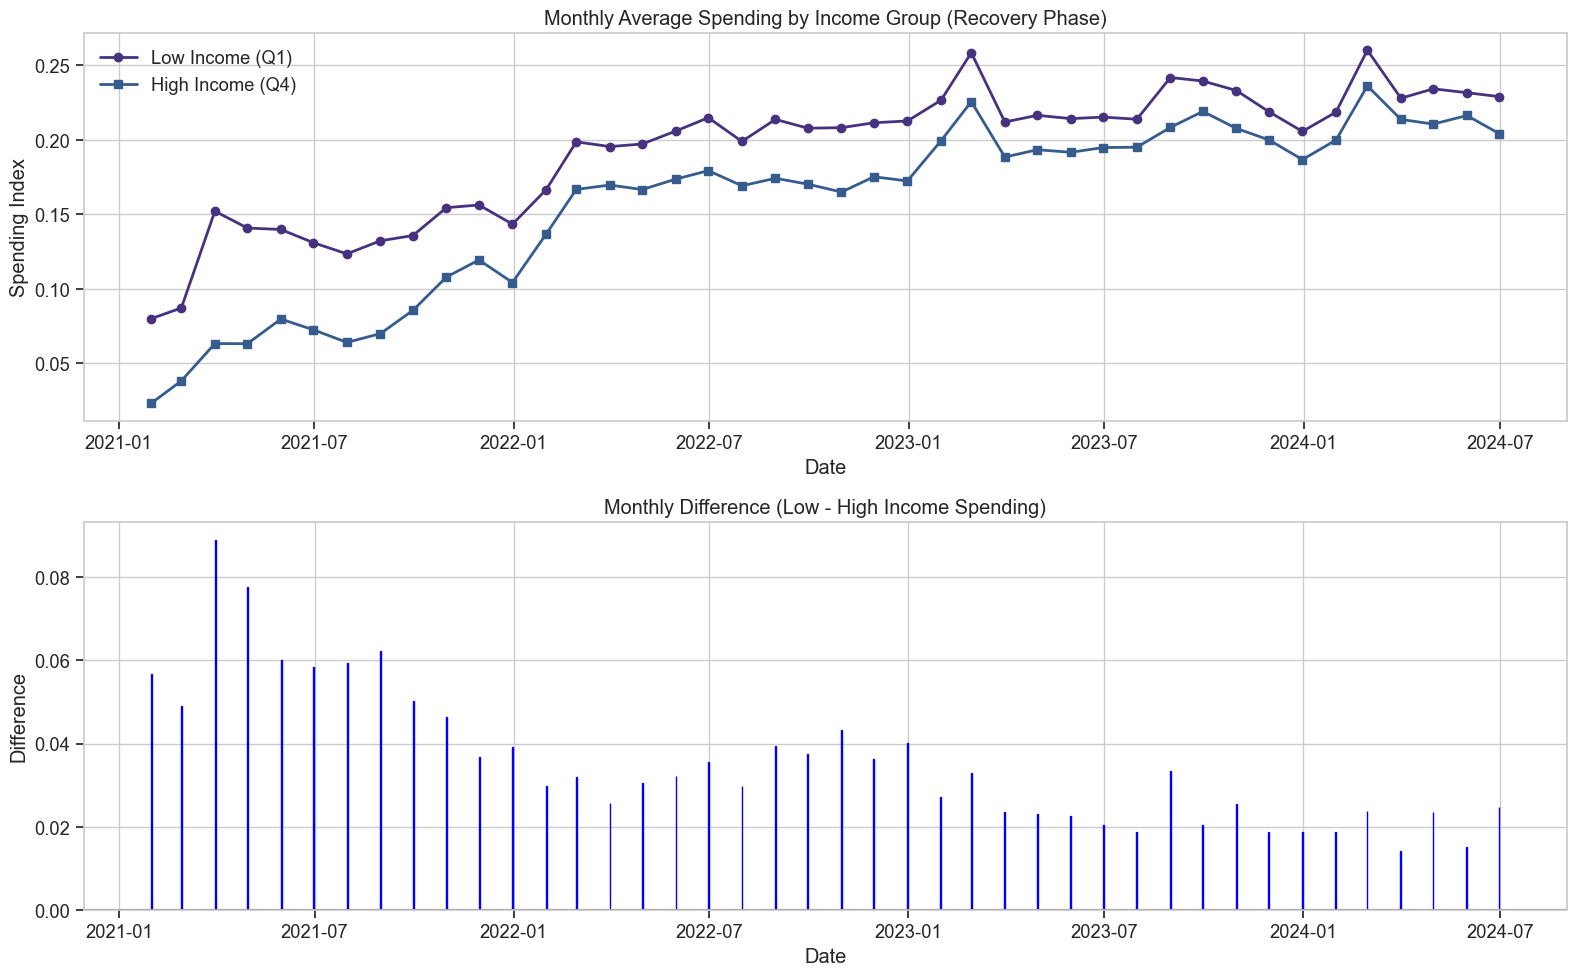

In [13]:
# 2. Plot time series
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(monthly_data['date'], monthly_data['spend_all_q1'], label='Low Income (Q1)', 
         marker='o', linewidth=2)
plt.plot(monthly_data['date'], monthly_data['spend_all_q4'], label='High Income (Q4)', 
         marker='s', linewidth=2)
plt.title('Monthly Average Spending by Income Group (Recovery Phase)')
plt.xlabel('Date')
plt.ylabel('Spending Index')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
bars = plt.bar(monthly_data['date'], monthly_data['difference'])
# Color the bars based on whether q1 is higher (blue) or lower (red) than q4
for i, diff in enumerate(monthly_data['difference']):
    bars[i].set_color('blue' if diff > 0 else 'red')
plt.title('Monthly Difference (Low - High Income Spending)')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.axhline(y=0, color='black', linestyle='-')
plt.grid(True)
plt.tight_layout()
plt.show()

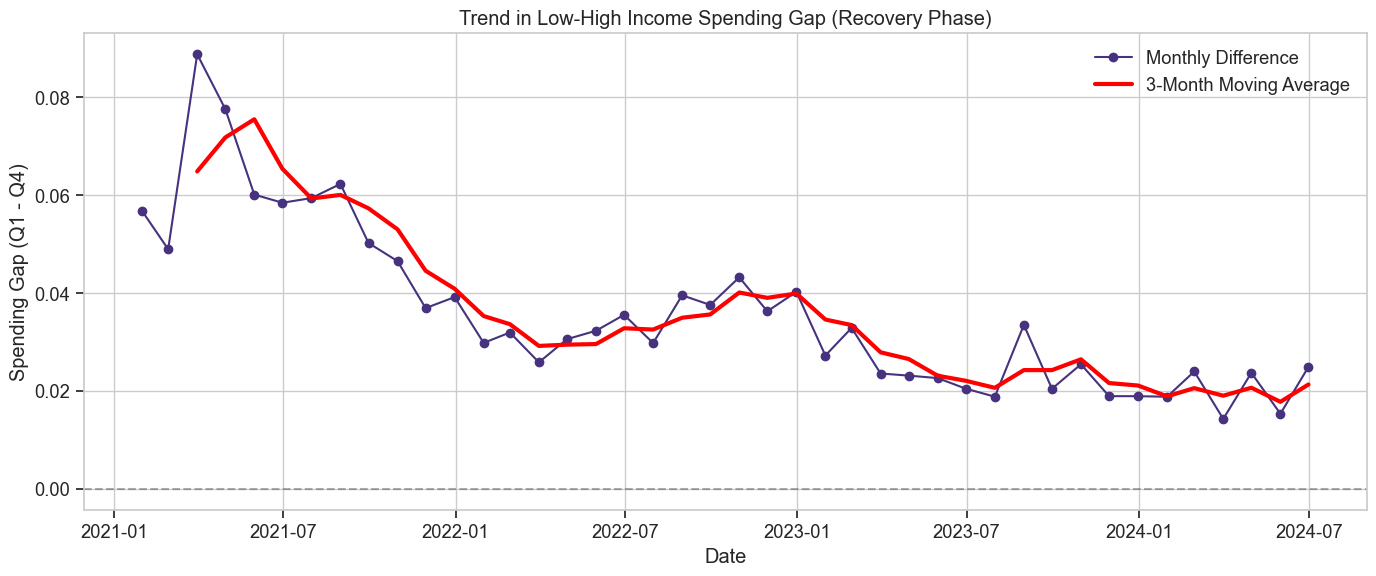

In [14]:
# 3. Moving average to show trend
monthly_data['rolling_diff'] = monthly_data['difference'].rolling(window=3).mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_data['date'], monthly_data['difference'], label='Monthly Difference', marker='o')
plt.plot(monthly_data['date'], monthly_data['rolling_diff'], label='3-Month Moving Average', 
         linewidth=3, color='red')
plt.title('Trend in Low-High Income Spending Gap (Recovery Phase)')
plt.xlabel('Date')
plt.ylabel('Spending Gap (Q1 - Q4)')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# 4. Calculate correlation between income groups
correlation = df_recovery['spend_all_q1'].corr(df_recovery['spend_all_q4'])
print(f"\nCorrelation between income groups: {correlation:.4f}")

# --------- SUMMARY STATISTICS AND REPORTING ---------
print("\n\nGenerating final summary and reporting...")




Correlation between income groups: 0.6041


Generating final summary and reporting...


In [16]:
# 1. Create summary table for reporting
summary_table = pd.DataFrame({
    'Metric': ['Sample Size', 'Q1 Mean', 'Q4 Mean', 'Mean Difference (Q1-Q4)', 
               'T-Statistic', 'P-Value', "Cohen's d", 'Effect Size', 
               'Correlation', 'Normality (Q1)', 'Normality (Q4)'],
    'Value': [len(df_recovery), 
             f"{df_recovery['spend_all_q1'].mean():.4f}", 
             f"{df_recovery['spend_all_q4'].mean():.4f}",
             f"{df_recovery['spend_all_q1'].mean() - df_recovery['spend_all_q4'].mean():.4f}",
             f"{t_stat:.4f}",
             f"< 0.001" if p_value < 0.001 else f"{p_value:.4f}",
             f"{cohens_d:.4f}",
             effect_interpretation,
             f"{correlation:.4f}",
             f"p = {p_q1:.6f} ({'Normal' if p_q1 > 0.05 else 'Not Normal'})",
             f"p = {p_q4:.6f} ({'Normal' if p_q4 > 0.05 else 'Not Normal'})"]
})

# Print the summary table instead of saving
print("\nSummary Table for RQ2 - Income-Based Spending Differences (Recovery Phase):")
print(summary_table.to_string(index=False))

# Remove this line that saves to CSV
# summary_table.to_csv('recovery_analysis_summary.csv', index=False)


Summary Table for RQ2 - Income-Based Spending Differences (Recovery Phase):
                 Metric                     Value
            Sample Size                     28215
                Q1 Mean                    0.1623
                Q4 Mean                    0.1170
Mean Difference (Q1-Q4)                    0.0453
            T-Statistic                   79.2404
                P-Value                   < 0.001
              Cohen's d                   -0.4199
            Effect Size                     small
            Correlation                    0.6041
         Normality (Q1) p = 0.000000 (Not Normal)
         Normality (Q4) p = 0.000000 (Not Normal)


In [17]:
# 3. Print final summary
print("\nSummary Table for RQ2 - Income-Based Spending Differences (Recovery Phase):")
for i, row in summary_table.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

print("\nAnalysis complete! All results have been saved to CSV files and visualizations to PNG files.")


Summary Table for RQ2 - Income-Based Spending Differences (Recovery Phase):
Sample Size: 28215
Q1 Mean: 0.1623
Q4 Mean: 0.1170
Mean Difference (Q1-Q4): 0.0453
T-Statistic: 79.2404
P-Value: < 0.001
Cohen's d: -0.4199
Effect Size: small
Correlation: 0.6041
Normality (Q1): p = 0.000000 (Not Normal)
Normality (Q4): p = 0.000000 (Not Normal)

Analysis complete! All results have been saved to CSV files and visualizations to PNG files.
